In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

data = pd.read_csv('Dataset/train.txt', sep=';')
data.columns = ['Text', 'Emotions']  
data.head()

,Text,Emotions
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness


In [2]:
data.Emotions.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [3]:
texts = data['Text'].tolist()
emotions = data['Emotions'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [4]:
sequences = tokenizer.texts_to_sequences(texts)
max_length_list = [len(seq) for seq in sequences]
max_length = max(max_length_list)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [5]:
encoder = LabelEncoder()
emotions = encoder.fit_transform(emotions)

In [6]:
emotions

array([4, 0, 3, ..., 2, 0, 4])

In [7]:
one_hot_labels = to_categorical(emotions)

In [8]:
one_hot_labels

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, 
                                                    one_hot_labels,
                                                    test_size=0.2)

In [10]:
# Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=len(one_hot_labels[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10


c:\Users\Pratham\anaconda3\envs\ai_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3857 - loss: 1.5249 - val_accuracy: 0.7372 - val_loss: 0.7746
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8783 - loss: 0.3864 - val_accuracy: 0.7891 - val_loss: 0.6299
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9844 - loss: 0.0560 - val_accuracy: 0.8191 - val_loss: 0.5921
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9967 - loss: 0.0203 - val_accuracy: 0.8234 - val_loss: 0.5801
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9976 - loss: 0.0142 - val_accuracy: 0.8206 - val_loss: 0.6296
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9984 - loss: 0.0096 - val_accuracy: 0.8197 - val_loss: 0.6725
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9980 - loss: 0.0102 - val_accuracy: 0.8138 - val_loss: 0.7113
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.8

In [11]:
# Example text for prediction
text = "she didn't come today because she lost her dog yesterday!"

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Emoji map for better output
emoji_map = {
    'happy': '😊', 
    'sad': '😢', 
    'angry': '😠', 
    'surprised': '😲',
    'neutral': '😐',
    'fear': '😨',
    'disgust': '🤢'
}

def test(input_text):
    # 1. Tokenize and pad
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_input_sequences = pad_sequences(input_sequence, maxlen=max_length)
    
    # 2. Predict
    prediction = model.predict(padded_input_sequences)[0]
    
    # 3. Predicted label
    predicted_index = np.argmax(prediction)
    predicted_label = encoder.inverse_transform([predicted_index])[0]
    emoji = emoji_map.get(predicted_label, '')

    # 4. Print main prediction
    print(f"Predicted Emotion: {predicted_label} {emoji}")

    # 5. Print all confidences
    print("\nConfidence Scores:")
    for i, prob in enumerate(prediction):
        label = encoder.inverse_transform([i])[0]
        print(f"{label:10s}: {prob:.2%}")

    # 6. Visualize (optional)
    labels = encoder.inverse_transform(list(range(len(prediction))))
    plt.figure(figsize=(8, 4))
    plt.bar(labels, prediction, color='skyblue')
    plt.title(f"Emotion Probabilities for: \"{input_text}\"")
    plt.ylabel("Confidence")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Emotion: anger 

Confidence Scores:
anger     : 38.15%
fear      : 15.12%
joy       : 29.46%
love      : 0.14%
sadness   : 16.99%
surprise  : 0.14%


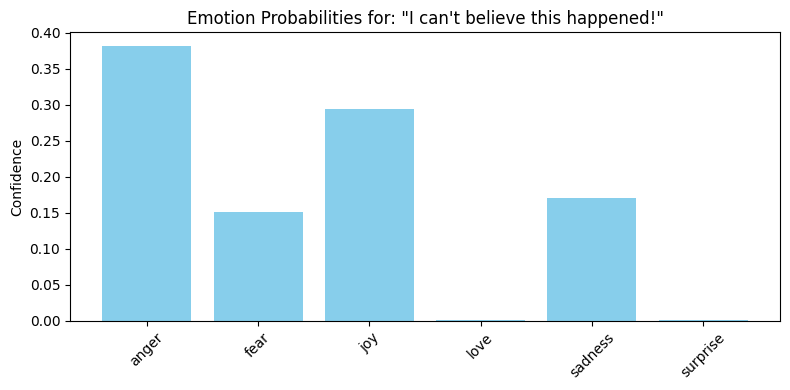

In [13]:
test("I can't believe this happened!")

In [14]:
import pickle as pk
filename = 'text_classification.pkl'
pk.dump(model, open(filename, 'wb'))